In [208]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew
from scipy.stats import kurtosis
sns.set(font_scale=1.5)

In [209]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [210]:
data = pd.read_csv ("Dati_Scania_status.csv")
data.shape

(404892, 19)

In [211]:
data = data.drop_duplicates().reset_index().drop(columns=['index'])
data.shape

(120269, 19)

## FEATURE ENGINEERING

In [214]:
data = data.sort_values(by=['LicensePlate', 'CreatedDateTime'])
data['day'] = data['CreatedDateTime'].str[:10]

df_tot = pd.DataFrame()

for name in set(data['LicensePlate']):
    df_truck = data[data['LicensePlate']==name]
    df_truck = df_truck[['day', 'Heading', 'Altitude', 'Speed', 'HRTotalVehicleDistance', 'EngineTotalFuelUsed']]
    df_gb = df_truck.groupby('day').agg(['max', 'min', 'mean', 'std', lambda x: rms(x), lambda x: skew(x), lambda x: kurtosis(x)]).rename(columns={'<lambda_0>': 'rms', '<lambda_1>': 'skew', '<lambda_2>': 'kurt'})

    df_gb.columns = list(map('_'.join, df_gb.columns.values))
    df_gb['Truck'] = name
    
    frames = [df_tot, df_gb]
    df_tot = pd.concat(frames)

In [215]:
df_tot

,Heading_max,Heading_min,Heading_mean,Heading_std,Heading_rms,Heading_skew,Heading_kurt,Altitude_max,Altitude_min,Altitude_mean,...,HRTotalVehicleDistance_skew,HRTotalVehicleDistance_kurt,EngineTotalFuelUsed_max,EngineTotalFuelUsed_min,EngineTotalFuelUsed_mean,EngineTotalFuelUsed_std,EngineTotalFuelUsed_rms,EngineTotalFuelUsed_skew,EngineTotalFuelUsed_kurt,Truck
day,,,,,,,,,,,,,,,,,,,,,
2021-05-28,337.0,33.0,150.444444,77.525117,168.255097,0.119690,0.540888,283.0,217.0,264.055556,...,1.007263,-0.966000,28513,28506,28509.111111,2.698341,28509.111232,0.507467,-1.231101,FV903SK
2021-05-29,357.0,2.0,163.857143,114.699942,199.228512,0.130057,-1.302188,303.0,227.0,278.500000,...,1.209316,0.080452,28549,28513,28531.119048,10.867724,28531.121068,0.325133,-1.059703,FV903SK
2021-05-30,217.0,217.0,217.000000,0.000000,217.000000,0.000000,-3.000000,231.0,231.0,231.000000,...,0.000000,-3.000000,28550,28549,28549.500000,0.522233,28549.500004,0.000000,-2.000000,FV903SK
2021-05-31,356.0,0.0,159.370370,115.717336,196.319751,0.223552,-1.385529,318.0,216.0,273.166667,...,0.595927,-1.157237,28596,28550,28575.777778,14.641201,28575.781459,0.061256,-1.372317,FV903SK
2021-06-01,360.0,0.0,177.914894,118.976035,213.325643,0.073890,-1.351424,298.0,219.0,274.255319,...,0.948194,-0.309962,28637,28596,28617.063830,13.067391,28617.066750,0.212350,-1.187191,FV903SK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-13,21.0,18.0,19.941176,1.477777,19.992646,-0.615457,-1.621212,50.0,49.0,49.647059,...,0.000000,-3.000000,24736,24735,24735.235294,0.437237,24735.235298,1.248075,-0.442308,FZ330SC
2022-01-14,327.0,18.0,213.942857,108.493682,239.177997,-0.502957,-1.220335,55.0,40.0,48.057143,...,0.214427,-1.212118,24756,24736,24746.771429,6.389724,24746.772230,0.143703,-1.245634,FZ330SC
2022-01-15,356.0,22.0,198.622222,107.525322,225.289937,-0.169290,-1.256687,54.0,38.0,44.600000,...,-0.233348,-1.444651,24786,24756,24773.022222,9.526253,24773.024013,-0.174067,-1.288024,FZ330SC


## FEATURE SELECTION

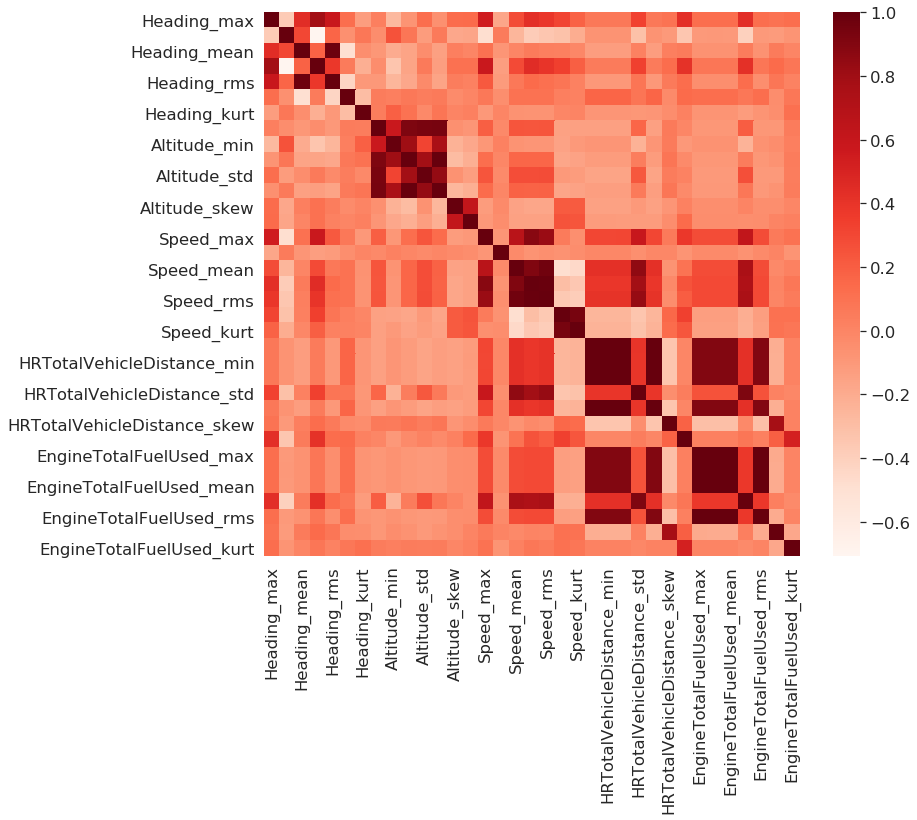

In [216]:
plt.figure(figsize=(12,10))

corr = df_tot.corr()

sns.heatmap(corr, cmap=plt.cm.Reds)
plt.show()

In [217]:
corr = df_tot.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = corr.columns[columns]

df_sel = df_tot[selected_columns].copy()
df_sel['Truck'] = df_tot['Truck']

selected_columns

Index(['Heading_max', 'Heading_min', 'Heading_mean', 'Heading_std',
       'Heading_skew', 'Heading_kurt', 'Altitude_max', 'Altitude_min',
       'Altitude_skew', 'Altitude_kurt', 'Speed_max', 'Speed_min',
       'Speed_mean', 'Speed_skew', 'HRTotalVehicleDistance_max',
       'HRTotalVehicleDistance_std', 'HRTotalVehicleDistance_skew',
       'HRTotalVehicleDistance_kurt', 'EngineTotalFuelUsed_skew',
       'EngineTotalFuelUsed_kurt'],
      dtype='object')

In [218]:
df_sel = df_sel.reset_index()
df_sel['day'] = pd.to_datetime(df_sel['day'], format='%Y-%m-%d')

df_sel

,day,Heading_max,Heading_min,Heading_mean,Heading_std,Heading_skew,Heading_kurt,Altitude_max,Altitude_min,Altitude_skew,...,Speed_min,Speed_mean,Speed_skew,HRTotalVehicleDistance_max,HRTotalVehicleDistance_std,HRTotalVehicleDistance_skew,HRTotalVehicleDistance_kurt,EngineTotalFuelUsed_skew,EngineTotalFuelUsed_kurt,Truck
0,2021-05-28,337.0,33.0,150.444444,77.525117,0.119690,0.540888,283.0,217.0,-0.749974,...,0.0,4.222222,3.880570,64549,6.283082,1.007263,-0.966000,0.507467,-1.231101,FV903SK
1,2021-05-29,357.0,2.0,163.857143,114.699942,0.130057,-1.302188,303.0,227.0,-1.363407,...,0.0,8.261905,2.559844,64629,23.772538,1.209316,0.080452,0.325133,-1.059703,FV903SK
2,2021-05-30,217.0,217.0,217.000000,0.000000,0.000000,-3.000000,231.0,231.0,0.000000,...,0.0,0.000000,0.000000,64629,0.000000,0.000000,-3.000000,0.000000,-2.000000,FV903SK
3,2021-05-31,356.0,0.0,159.370370,115.717336,0.223552,-1.385529,318.0,216.0,-0.627787,...,0.0,8.555556,2.504610,64720,29.599239,0.595927,-1.157237,0.061256,-1.372317,FV903SK
4,2021-06-01,360.0,0.0,177.914894,118.976035,0.073890,-1.351424,298.0,219.0,-1.015004,...,0.0,4.170213,3.459793,64797,23.342303,0.948194,-0.309962,0.212350,-1.187191,FV903SK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,2022-01-13,21.0,18.0,19.941176,1.477777,-0.615457,-1.621212,50.0,49.0,-0.615457,...,0.0,0.000000,0.000000,67430,0.000000,0.000000,-3.000000,1.248075,-0.442308,FZ330SC
2197,2022-01-14,327.0,18.0,213.942857,108.493682,-0.502957,-1.220335,55.0,40.0,-0.036123,...,0.0,7.257143,2.184113,67485,17.544565,0.214427,-1.212118,0.143703,-1.245634,FZ330SC
2198,2022-01-15,356.0,22.0,198.622222,107.525322,-0.169290,-1.256687,54.0,38.0,0.338103,...,0.0,9.755556,1.974294,67560,24.648704,-0.233348,-1.444651,-0.174067,-1.288024,FZ330SC
2199,2022-01-17,355.0,25.0,205.478873,100.920316,-0.330766,-1.163675,71.0,39.0,1.634258,...,0.0,6.042254,1.977867,67644,23.479740,-0.388844,-0.884769,-0.456384,-1.004510,FZ330SC


## MERGE CON FATTURE

In [219]:
df_fatture = pd.read_excel("fatture_filtered.xlsx")

# Scommentare per considerare solo un particolare gruppo di fatture 
df_fatture = df_fatture[df_fatture['Categoria componente']=='Impianto di lubrificazione motore']

df_fatture = df_fatture[['Targa', 'Data', 'label']]
df_fatture = df_fatture[df_fatture['Targa'].isin(set(df_sel['Truck']))]
len(df_fatture)

7

In [220]:
df_sel['label'] = 0

def nearest(items, pivot):
    time = min(items, key=lambda x: abs(x - pivot))
    return pd.to_datetime(time, format='%Y-%m-%d')

In [221]:
## Parametro da cambiare per settare l'horizon di predizione
h = 20

In [222]:
from datetime import datetime, timedelta

df_fatture = df_fatture.reset_index(drop=True)
for i in range(df_fatture.shape[0]):
    t = df_fatture['Targa'][i]
    d = df_fatture['Data'][i]
    
    df_truck = df_sel[df_sel['Truck'] == t]
    min_ind = nearest(df_truck['day'], d)
    df_sel.loc[(df_sel['Truck']==t) & (df_sel['day'] == min_ind), 'label'] = 1
    for i in range(1, h):
        df_sel.loc[(df_sel['Truck']==t) & (df_sel['day'] == min_ind-timedelta(days=i)), 'label'] = 1
    
df_sel['label'].value_counts()

0    2126
1      75
Name: label, dtype: int64

### PREDICTIVE MODEL

In [223]:
df_exp = df_sel.drop(columns=['Truck', 'day'])
df_exp

,Heading_max,Heading_min,Heading_mean,Heading_std,Heading_skew,Heading_kurt,Altitude_max,Altitude_min,Altitude_skew,Altitude_kurt,...,Speed_min,Speed_mean,Speed_skew,HRTotalVehicleDistance_max,HRTotalVehicleDistance_std,HRTotalVehicleDistance_skew,HRTotalVehicleDistance_kurt,EngineTotalFuelUsed_skew,EngineTotalFuelUsed_kurt,label
0,337.0,33.0,150.444444,77.525117,0.119690,0.540888,283.0,217.0,-0.749974,-1.365260,...,0.0,4.222222,3.880570,64549,6.283082,1.007263,-0.966000,0.507467,-1.231101,0
1,357.0,2.0,163.857143,114.699942,0.130057,-1.302188,303.0,227.0,-1.363407,0.134975,...,0.0,8.261905,2.559844,64629,23.772538,1.209316,0.080452,0.325133,-1.059703,0
2,217.0,217.0,217.000000,0.000000,0.000000,-3.000000,231.0,231.0,0.000000,-3.000000,...,0.0,0.000000,0.000000,64629,0.000000,0.000000,-3.000000,0.000000,-2.000000,0
3,356.0,0.0,159.370370,115.717336,0.223552,-1.385529,318.0,216.0,-0.627787,-1.331867,...,0.0,8.555556,2.504610,64720,29.599239,0.595927,-1.157237,0.061256,-1.372317,0
4,360.0,0.0,177.914894,118.976035,0.073890,-1.351424,298.0,219.0,-1.015004,-0.761349,...,0.0,4.170213,3.459793,64797,23.342303,0.948194,-0.309962,0.212350,-1.187191,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,21.0,18.0,19.941176,1.477777,-0.615457,-1.621212,50.0,49.0,-0.615457,-1.621212,...,0.0,0.000000,0.000000,67430,0.000000,0.000000,-3.000000,1.248075,-0.442308,0
2197,327.0,18.0,213.942857,108.493682,-0.502957,-1.220335,55.0,40.0,-0.036123,0.362285,...,0.0,7.257143,2.184113,67485,17.544565,0.214427,-1.212118,0.143703,-1.245634,0
2198,356.0,22.0,198.622222,107.525322,-0.169290,-1.256687,54.0,38.0,0.338103,0.006185,...,0.0,9.755556,1.974294,67560,24.648704,-0.233348,-1.444651,-0.174067,-1.288024,0
2199,355.0,25.0,205.478873,100.920316,-0.330766,-1.163675,71.0,39.0,1.634258,1.623731,...,0.0,6.042254,1.977867,67644,23.479740,-0.388844,-0.884769,-0.456384,-1.004510,0


In [224]:
Y = df_exp['label'].copy()
X = df_exp.drop(columns=['label'])

In [225]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings('ignore')

model = XGBClassifier()
loo = LeaveOneOut()
pred = cross_val_predict(model,X,Y,cv=50)

print()
print(classification_report(Y, pred, target_names=['0', '1']))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2126
           1       0.32      0.11      0.16        75

    accuracy                           0.96      2201
   macro avg       0.64      0.55      0.57      2201
weighted avg       0.95      0.96      0.95      2201



### Prediction with only one trucks ###

In [226]:
truck = 'FZ330SC'

df_truck = df_sel[df_sel['Truck']== truck]
df_truck = df_truck.drop(columns=['Truck', 'day'])

In [227]:
df_truck['label'].value_counts()

0    124
1     26
Name: label, dtype: int64

In [228]:
Y = df_truck['label'].copy()
X = df_truck.drop(columns=['label'])

In [229]:
model = XGBClassifier()
loo = LeaveOneOut()
pred = cross_val_predict(model,X,Y,cv=loo)

print()
print(classification_report(Y, pred, target_names=['0', '1']))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       124
           1       0.92      0.88      0.90        26

    accuracy                           0.97       150
   macro avg       0.95      0.93      0.94       150
weighted avg       0.97      0.97      0.97       150



### One truck for training and others for test

In [234]:
df_sel[df_sel['label']==1]['Truck'].value_counts()

FZ330SC    26
FV907SK    18
FV914SK    16
FV913SK    15
Name: Truck, dtype: int64

In [235]:
df_train = df_sel[df_sel['Truck'].isin(['FZ330SC'])]
df_train = df_train.drop(columns=['Truck', 'day'])

In [236]:
df_test = df_sel[df_sel['Truck'].isin(['FV907SK', 'FV914SK', 'FV913SK'])]
df_test = df_test.drop(columns=['Truck', 'day'])

In [237]:
Y_train = df_train['label'].copy()
X_train = df_train.drop(columns=['label'])

Y_test = df_test['label'].copy()
X_test = df_test.drop(columns=['label'])

In [238]:
model = XGBClassifier(scale_pos_weight=5)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print(classification_report(Y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       479
           1       0.05      0.08      0.06        49

    accuracy                           0.77       528
   macro avg       0.48      0.46      0.47       528
weighted avg       0.82      0.77      0.80       528

